# Notebook Setup

In [2]:
#TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
#MY_HOME_ABS_PATH = "/Users/jetcalz07/Desktop/MIDS/W210_Capstone/co2-flux-hourly-gpp-modeling"
MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling"

## Import Modules

In [3]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import sys
import math
import json
import time
import pandas as pd
import numpy as np
from calendar import monthrange
from datetime import datetime
from io import BytesIO
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold


# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Define Local File System Constants

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
raw_data_dir = tmp_dir
data_dir = root_dir + os.sep + 'data'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'
model_objects_dir = root_dir + os.sep + 'code/src/modeling/model_objects'

# Load Train and Test dataset from Azure Storage Blob

In [5]:
# Define dataset
container = "all-sites-data"
ext = "parquet"
ver = "mvp"
model = "rfr"
train_blob_name = f"{model}-full_2010_2015-train-v-{ver}.{ext}"
val_blob_name = f"{model}-full_2010_2015-val-v-{ver}.{ext}"
test_blob_name = f"{model}-full_2010_2015-test-v-{ver}.{ext}"

In [21]:
# Load splits from Azure
azStorageClient = AzStorageClient(az_cred_file)

train_fs = azStorageClient.downloadBlob2Stream(container, train_blob_name)
train_df = pd.read_parquet(train_fs, engine='pyarrow')

val_fs = azStorageClient.downloadBlob2Stream(container, val_blob_name)
val_df = pd.read_parquet(val_fs, engine='pyarrow')

test_fs = azStorageClient.downloadBlob2Stream(container, test_blob_name)
test_df = pd.read_parquet(test_fs, engine='pyarrow')

# Train RFR Model

In [22]:
# Prep x, y dataset for train
target_variable = 'GPP_NT_VUT_REF'
drop_cols = ['site_id', 'timestep_idx_local', 'timestep_idx_global', 'index', 'datetime','gap_flag_hour', 'gap_flag_month']

X_train = train_df.drop([target_variable] + drop_cols, axis=1)
y_train = train_df[target_variable]
X_val = val_df.drop([target_variable] + drop_cols, axis=1)
y_val = val_df[target_variable]
X_test = test_df.drop([target_variable] + drop_cols, axis=1)
y_test = test_df[target_variable]

# Join train and val into one for CV
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)

In [8]:
tune = False
n_splits = 4

if tune:

    # Define the model parameters for CV
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10],
        'max_features': [1.0, 'sqrt', 'log2']
    }

    # Fit RFR model with GridSearch tuning
    start_time = time.time()

    rf_model = RandomForestRegressor(random_state=42)
    model = GridSearchCV(rf_model, param_grid=param_grid, cv=n_splits, n_jobs=-1, verbose=1)
    model.fit(X_train, y_train)

    end_time = time.time()
    print(f"Elapsed time: {(end_time - start_time)/60:.2f} minutes")

    # Print best params
    best_params = model.best_params_
    print(best_params)

## Save tuned model object

In [9]:
model_save_path = os.path.join(model_objects_dir, 'rfr_mvp_tuned.pkl')

if tune: 
    joblib.dump(model, model_save_path)
else: 
    model = joblib.load(model_save_path)
    best_params = model.get_params()

## Evaluate each fold

In [ ]:
# Redefine the model using the best parameters
tuned_rf_regressor = RandomForestRegressor(**best_params, random_state=42)
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Get metrics for each fold given model configuration
r2_scores = cross_val_score(tuned_rf_regressor, X_train, y_train, cv=kfold, scoring='r2')
neg_mse_scores = cross_val_score(tuned_rf_regressor, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
mae_scores = cross_val_score(tuned_rf_regressor, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')

In [ ]:
# Flip the neg_mse
def rmse_neg_mse(neg_mse):
    return np.sqrt(-neg_mse)

rmse_scores = rmse_neg_mse(neg_mse_scores)

In [ ]:
# Print performance metrics for each fold
for i in range(k):
    print(f"Fold {i+1}: R^2 = {r2_scores[i]:.3f}, RMSE = {rmse_scores[i]:.3f}, MAE = {-mae_scores[i]:.3f}")

## Evaluate RFR on Val & Test Set

In [10]:
# Predict on val/test sets
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Evaluate predictions - VAL
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print(f"Val RMSE: {rmse}")
print(f"Val MAE: {mae}")
print(f"Val R2/NSE: {r2}")

# Evaluate predictions - TEST
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print(f"\nTest RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R2/NSE: {r2}")

Val RMSE: 3.8403763113868505
Val MAE: 2.220654892812136
Val R2/NSE: 0.7230154187161593

Test RMSE: 3.664349571956649
Test MAE: 2.0065062435396412
Test R2/NSE: 0.6797643290176278


## Get performance by IGBP type

In [46]:
# Get categorical feature back from dummies
igbp_cols = [x for x in test_df.columns if 'IGBP_' in x]
test_df['MODIS_IGBP'] = test_df[igbp_cols].idxmax(axis=1)
test_df['MODIS_IGBP'] = test_df['MODIS_IGBP'].apply(lambda x: x.split("_")[-1])

# Subset df
test_trim = test_df[['MODIS_IGBP', 'GPP_NT_VUT_REF']].copy()
test_trim['y_pred'] = y_pred_test

# Get metrics by group
igbp_group_metrics = {}
groups = test_df['MODIS_IGBP'].unique()
for group in groups:
    test_group = test_trim.loc[test_trim['MODIS_IGBP']==group, ].copy()
    
    # Get metrics
    rmse = np.sqrt(mean_squared_error(test_group['GPP_NT_VUT_REF'], test_group['y_pred']))
    mae = mean_absolute_error(test_group['GPP_NT_VUT_REF'], test_group['y_pred'])
    r2 = r2_score(test_group['GPP_NT_VUT_REF'], test_group['y_pred'])
    
    # Save to dict
    igbp_group_metrics[group] = {'RMSE': round(rmse, 2), 'MAE': round(mae, 2), 'R2': round(r2, 2)}
    
igbp_metric_df = pd.DataFrame.from_dict(igbp_group_metrics, orient='index')
igbp_metric_df = igbp_metric_df.reset_index().rename(columns={'index': 'MODIS_IGBP'})
igbp_metric_df

,MODIS_IGBP,RMSE,MAE,R2
0,DBF,3.84000,2.10000,0.82000
1,MF,3.00000,1.92000,0.81000
2,WET,2.73000,1.68000,0.78000
3,ENF,3.69000,2.28000,0.73000
4,GRA,1.72000,1.07000,0.71000
5,CRO,5.12000,2.70000,0.58000
6,SAV,2.81000,1.58000,0.58000
7,WSA,6.34000,4.14000,0.33000
8,OSH,1.25000,0.73000,-0.01000


In [48]:
# compute the percentage of the dataset represented by each group
group_sizes = test_trim.groupby('MODIS_IGBP').size()
percentages = group_sizes / len(test_trim) * 100
group_stats = test_trim.groupby('MODIS_IGBP')['GPP_NT_VUT_REF'].agg(['mean', 'var'])
group_stats.columns = ['mean_GPP', 'var_GPP']
group_stats['percent_dataset'] = percentages
group_stats = group_stats.reset_index()

merged_df = pd.merge(group_stats, igbp_metric_df, on='MODIS_IGBP')
merged_df.sort_values('R2', ascending=False, inplace=True)
merged_df

,MODIS_IGBP,mean_GPP,var_GPP,percent_dataset,RMSE,MAE,R2
1,DBF,4.34944,80.20588,5.59371,3.84000,2.10000,0.82000
4,MF,4.04317,47.94906,14.92252,3.00000,1.92000,0.81000
7,WET,2.85502,33.92379,5.56307,2.73000,1.68000,0.78000
2,ENF,4.39118,49.85586,15.86714,3.69000,2.28000,0.73000
3,GRA,1.42292,10.06766,11.85887,1.72000,1.07000,0.71000
0,CRO,4.34011,62.82785,16.14287,5.12000,2.70000,0.58000
6,SAV,1.94456,18.81930,15.20080,2.81000,1.58000,0.58000
8,WSA,2.56527,59.98900,6.92895,6.34000,4.14000,0.33000
5,OSH,0.07602,1.54997,7.92208,1.25000,0.73000,-0.01000


## Feature Importances

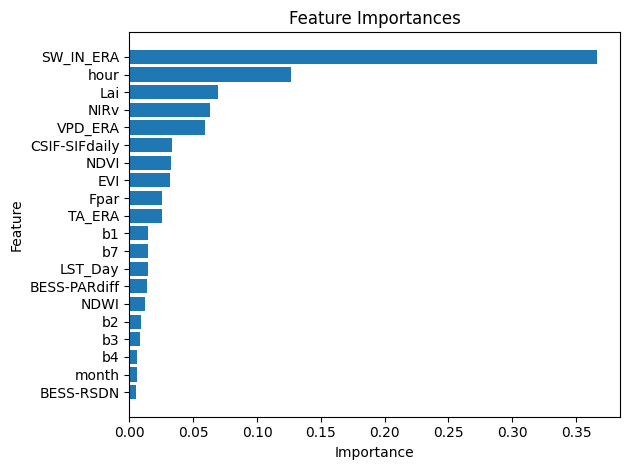

In [53]:
# get the feature importances
best_rf = model.best_estimator_
importances = pd.Series(best_rf.feature_importances_, index=X_test.columns).sort_values(ascending=False)


# Visualize
importances_sorted = importances.sort_values(ascending=True)[-20:]

fig, ax = plt.subplots()
ax.barh(importances_sorted.index, importances_sorted.values)
ax.set_title('Feature Importances')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
fig.tight_layout()
plt.show()

In [49]:
print(importances)

SW_IN_ERA         0.36612
hour              0.12699
Lai               0.06946
NIRv              0.06277
VPD_ERA           0.05913
CSIF-SIFdaily     0.03317
NDVI              0.03232
EVI               0.03212
Fpar              0.02548
TA_ERA            0.02528
b1                0.01469
b7                0.01451
LST_Day           0.01451
BESS-PARdiff      0.01361
NDWI              0.01206
b2                0.00879
b3                0.00858
b4                0.00596
month             0.00564
BESS-RSDN         0.00551
LW_IN_ERA         0.00528
LST_Night         0.00503
Ts                0.00493
BESS-PAR          0.00433
PET               0.00430
b6                0.00355
MODIS_LC          0.00342
ESACCI-sm         0.00321
c4_percent        0.00293
koppen_sub        0.00290
b5                0.00246
koppen_main       0.00231
P_ERA             0.00223
c3c4_rotation     0.00220
PA_ERA            0.00198
MODIS_IGBP_MF     0.00164
MODIS_IGBP_WAT    0.00122
MODIS_IGBP_WSA    0.00115
MODIS_PFT_MF